# A Gentle Introduction to Transfer Learning

In [19]:
import sys
import os
import numpy as np
import pandas as pd
from collections import Counter
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import lr_scheduler, SGD
from torch.autograd import Variable
from torchvision import models
from utils import (get_gpu_name, get_number_processors, plot_pytorch_data_stream, train_model, create_dataset, 
                   available_models, plot_metrics)

print("OS: ", sys.platform)
print("Python: ", sys.version)
print("PyTorch: ", torch.__version__)
print("Numpy: ", np.__version__)
print("Number of CPU processors: ", get_number_processors())
print("GPU: ", get_gpu_name())

%matplotlib inline
%load_ext autoreload
%autoreload 2

OS:  linux
Python:  3.5.4 | packaged by conda-forge | (default, Nov  4 2017, 10:11:29) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]
PyTorch:  0.2.0_3
Numpy:  1.13.3
Number of CPU processors:  24
GPU:  ['Tesla M60', 'Tesla M60', 'Tesla M60', 'Tesla M60']
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
torch.backends.cudnn.benchmark=True # enables cudnn's auto-tuner

In [3]:
MODEL_NAME = 'resnet18'
BATCH_SIZE = 64
SETS = ['train', 'val']
NUM_GPUS = 4
EPOCHS = 20
LR = 0.001
LR_STEP = 0.1
LR_EPOCHS = 7
MOMENTUM = 0.9

## Model and utilities

In [4]:
model_names = available_models()
print(model_names)

['alexnet', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'inception_v3', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']


In [5]:
def finetune(dataloaders, model_name, sets, num_epochs, num_gpus, lr, momentum, lr_step, lr_epochs, verbose=True):
    #Class adaptation
    num_class = len(dataloaders[sets[0]].dataset.class_to_idx)
    model_ft = models.__dict__[model_name](pretrained=True)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_class)
    
    #gpus
    if num_gpus > 1: 
        model_ft = nn.DataParallel(model_ft)
    model_ft = model_ft.cuda()
    
    #loss
    criterion = nn.CrossEntropyLoss()

    # All parameters are being optimized
    optimizer = SGD(model_ft.parameters(), lr=lr, momentum=momentum)

    # Decay LR by a factor of lr_step every lr_epochs epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_epochs, gamma=lr_step)
    model_ft = train_model(dataloaders, model_ft, sets, criterion, optimizer, exp_lr_scheduler, 
                           num_epochs=num_epochs, verbose=verbose)
    return model_ft

In [6]:
def freeze_and_train(dataloaders, model_name, sets, num_epochs, num_gpus, lr, momentum, lr_step, lr_epochs, verbose=True):
    #Class adaptation
    num_class = len(dataloaders[sets[0]].dataset.class_to_idx)
    model_conv = models.__dict__[model_name](pretrained=True)
    for param in model_conv.parameters(): #params have requires_grad=True by default
        param.requires_grad = False
    num_ftrs = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_ftrs, num_class)
    
    #gpus
    if num_gpus > 1: 
        model_conv = nn.DataParallel(model_conv)
    model_conv = model_conv.cuda()
    
    #loss
    criterion = nn.CrossEntropyLoss()

    # Only parameters of final layer are being optimized 
    if num_gpus > 1:
        params = model_conv.module.fc.parameters()
    else:
        params = model_conv.fc.parameters()
    optimizer = SGD(params, lr=lr, momentum=momentum)

    # Decay LR by a factor of lr_step every lr_epochs epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=lr_epochs, gamma=lr_step)
    model_conv = train_model(dataloaders, model_conv, sets, criterion, optimizer, exp_lr_scheduler, 
                             num_epochs=num_epochs, verbose=verbose)
    return model_conv

## Datasets
We are going to use the dataset [hymenoptera](https://download.pytorch.org/tutorial/hymenoptera_data.zip)

In [14]:
DATA_ROOT = '/datadrive'
HYMENOPTERA_ROOT = os.path.join(DATA_ROOT, 'hymenoptera_data')
HYMENOPTERA_GRAY_ROOT = os.path.join(DATA_ROOT, 'hymenoptera_gray')
SIMPSONS_ROOT = os.path.join(DATA_ROOT, 'simpsons', 'simpsons')
SIMPSONS_GRAY_ROOT = os.path.join(DATA_ROOT, 'simpsons', 'simpsons_gray')
DOGS_CATS_ROOT = os.path.join(DATA_ROOT, 'dogs_vs_cats', 'dogs_vs_cats')
DOGS_CATS_GRAY_ROOT = os.path.join(DATA_ROOT, 'dogs_vs_cats', 'dogs_vs_cats_gray')
CALTECH256_ROOT = os.path.join(DATA_ROOT, 'caltech256','caltech256')
CALTECH256_GRAY_ROOT = os.path.join(DATA_ROOT, 'caltech256','caltech256')

In [8]:
data_hymenoptera = create_dataset(HYMENOPTERA_ROOT, batch_size=BATCH_SIZE)

There are 2 clases in the dataset: {
    "ants": 0,
    "bees": 1
}
Sets sizes:  {
    "train": 244,
    "val": 153
}
Number of items in set train: {0: 123, 1: 121}
Number of items in set val: {0: 70, 1: 83}


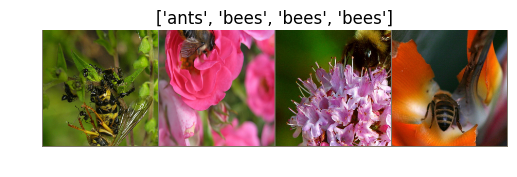

In [9]:
plot_pytorch_data_stream(data_hymenoptera['train'], max_images=4)

In [14]:
data_hymenoptera_gray = create_dataset(HYMENOPTERA_GRAY_ROOT, batch_size=BATCH_SIZE)

There are 2 clases in the dataset: {
    "ants": 0,
    "bees": 1
}
Sets sizes:  {
    "train": 244,
    "val": 153
}
Number of items in set train: {0: 123, 1: 121}
Number of items in set val: {0: 70, 1: 83}


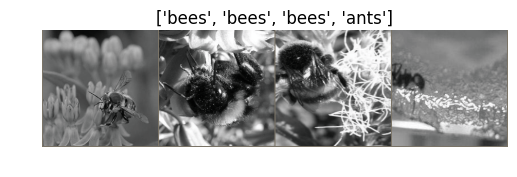

In [15]:
plot_pytorch_data_stream(data_hymenoptera_gray['train'], max_images=4)

In [36]:
data_simpsons = create_dataset(SIMPSONS_ROOT, batch_size=BATCH_SIZE*NUM_GPUS)

There are 20 clases in the dataset: {
    "abraham_grampa_simpson": 0,
    "apu_nahasapeemapetilon": 1,
    "bart_simpson": 2,
    "charles_montgomery_burns": 3,
    "chief_wiggum": 4,
    "comic_book_guy": 5,
    "edna_krabappel": 6,
    "homer_simpson": 7,
    "kent_brockman": 8,
    "krusty_the_clown": 9,
    "lenny_leonard": 10,
    "lisa_simpson": 11,
    "marge_simpson": 12,
    "mayor_quimby": 13,
    "milhouse_van_houten": 14,
    "moe_szyslak": 15,
    "ned_flanders": 16,
    "nelson_muntz": 17,
    "principal_skinner": 18,
    "sideshow_bob": 19
}
Sets sizes:  {
    "train": 15638,
    "val": 3910
}
Number of items in set train: {0: 730, 1: 498, 2: 1074, 3: 954, 4: 789, 5: 375, 6: 366, 7: 1797, 8: 398, 9: 965, 10: 248, 11: 1083, 12: 1033, 13: 197, 14: 863, 15: 1162, 16: 1163, 17: 286, 18: 955, 19: 702}
Number of items in set val: {0: 183, 1: 125, 2: 268, 3: 239, 4: 197, 5: 94, 6: 91, 7: 449, 8: 100, 9: 241, 10: 62, 11: 271, 12: 258, 13: 49, 14: 216, 15: 290, 16: 291, 17: 72, 

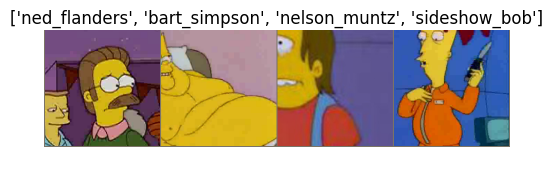

In [37]:
plot_pytorch_data_stream(data_simpsons['train'], max_images=4)

In [29]:
data_simpsons_gray = create_dataset(SIMPSONS_GRAY_ROOT, batch_size=BATCH_SIZE*NUM_GPUS)

There are 20 clases in the dataset: {
    "abraham_grampa_simpson": 0,
    "apu_nahasapeemapetilon": 1,
    "bart_simpson": 2,
    "charles_montgomery_burns": 3,
    "chief_wiggum": 4,
    "comic_book_guy": 5,
    "edna_krabappel": 6,
    "homer_simpson": 7,
    "kent_brockman": 8,
    "krusty_the_clown": 9,
    "lenny_leonard": 10,
    "lisa_simpson": 11,
    "marge_simpson": 12,
    "mayor_quimby": 13,
    "milhouse_van_houten": 14,
    "moe_szyslak": 15,
    "ned_flanders": 16,
    "nelson_muntz": 17,
    "principal_skinner": 18,
    "sideshow_bob": 19
}
Sets sizes:  {
    "train": 15638,
    "val": 3910
}
Number of items in set train: {0: 730, 1: 498, 2: 1074, 3: 954, 4: 789, 5: 375, 6: 366, 7: 1797, 8: 398, 9: 965, 10: 248, 11: 1083, 12: 1033, 13: 197, 14: 863, 15: 1162, 16: 1163, 17: 286, 18: 955, 19: 702}
Number of items in set val: {0: 183, 1: 125, 2: 268, 3: 239, 4: 197, 5: 94, 6: 91, 7: 449, 8: 100, 9: 241, 10: 62, 11: 271, 12: 258, 13: 49, 14: 216, 15: 290, 16: 291, 17: 72, 

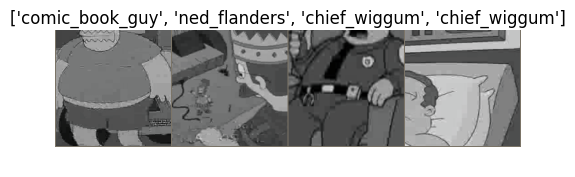

In [30]:
plot_pytorch_data_stream(data_simpsons_gray['train'], max_images=4)

In [14]:
data_dogs_vs_cats = create_dataset(DOGS_CATS_ROOT, batch_size=BATCH_SIZE*NUM_GPUS)

There are 2 clases in the dataset: {
    "cats": 0,
    "dogs": 1
}
Sets sizes:  {
    "train": 20000,
    "val": 5000
}
Number of items in set train: {0: 10000, 1: 10000}
Number of items in set val: {0: 2500, 1: 2500}


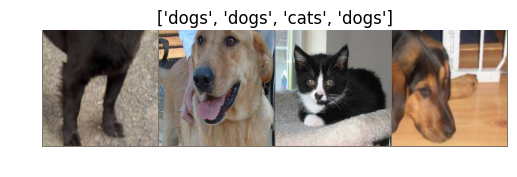

In [15]:
plot_pytorch_data_stream(data_dogs_vs_cats['train'], max_images=4)

In [22]:
data_dogs_vs_cats_gray = create_dataset(DOGS_CATS_GRAY_ROOT, batch_size=BATCH_SIZE*NUM_GPUS)

There are 2 clases in the dataset: {
    "cats": 0,
    "dogs": 1
}
Sets sizes:  {
    "train": 20000,
    "val": 5000
}
Number of items in set train: {0: 10000, 1: 10000}
Number of items in set val: {0: 2500, 1: 2500}


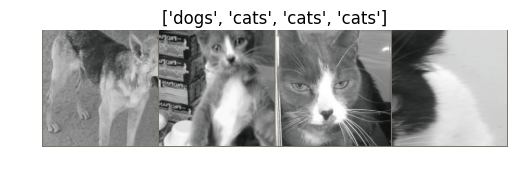

In [23]:
plot_pytorch_data_stream(data_dogs_vs_cats_gray['train'], max_images=4)

In [8]:
data_caltech256 = create_dataset(CALTECH256_ROOT, batch_size=BATCH_SIZE)

There are 257 clases in the dataset: {
    "001.ak47": 0,
    "002.american-flag": 1,
    "003.backpack": 2,
    "004.baseball-bat": 3,
    "005.baseball-glove": 4,
    "006.basketball-hoop": 5,
    "007.bat": 6,
    "008.bathtub": 7,
    "009.bear": 8,
    "010.beer-mug": 9,
    "011.billiards": 10,
    "012.binoculars": 11,
    "013.birdbath": 12,
    "014.blimp": 13,
    "015.bonsai-101": 14,
    "016.boom-box": 15,
    "017.bowling-ball": 16,
    "018.bowling-pin": 17,
    "019.boxing-glove": 18,
    "020.brain-101": 19,
    "021.breadmaker": 20,
    "022.buddha-101": 21,
    "023.bulldozer": 22,
    "024.butterfly": 23,
    "025.cactus": 24,
    "026.cake": 25,
    "027.calculator": 26,
    "028.camel": 27,
    "029.cannon": 28,
    "030.canoe": 29,
    "031.car-tire": 30,
    "032.cartman": 31,
    "033.cd": 32,
    "034.centipede": 33,
    "035.cereal-box": 34,
    "036.chandelier-101": 35,
    "037.chess-board": 36,
    "038.chimp": 37,
    "039.chopsticks": 38,
    "040.cockro

Number of items in set val: {0: 20, 1: 19, 2: 30, 3: 25, 4: 30, 5: 18, 6: 21, 7: 46, 8: 20, 9: 19, 10: 56, 11: 43, 12: 20, 13: 17, 14: 24, 15: 18, 16: 21, 17: 20, 18: 25, 19: 17, 20: 28, 21: 19, 22: 22, 23: 22, 24: 23, 25: 21, 26: 20, 27: 22, 28: 21, 29: 21, 30: 18, 31: 20, 32: 20, 33: 20, 34: 17, 35: 21, 36: 24, 37: 22, 38: 17, 39: 25, 40: 17, 41: 17, 42: 25, 43: 24, 44: 17, 45: 27, 46: 19, 47: 21, 48: 21, 49: 19, 50: 23, 51: 17, 52: 16, 53: 24, 54: 20, 55: 20, 56: 21, 57: 19, 58: 17, 59: 17, 60: 20, 61: 17, 62: 24, 63: 26, 64: 20, 65: 17, 66: 17, 67: 22, 68: 20, 69: 17, 70: 20, 71: 24, 72: 20, 73: 23, 74: 17, 75: 17, 76: 18, 77: 18, 78: 20, 79: 23, 80: 19, 81: 16, 82: 19, 83: 17, 84: 22, 85: 16, 86: 19, 87: 20, 88: 22, 89: 42, 90: 19, 91: 40, 92: 22, 93: 21, 94: 17, 95: 57, 96: 18, 97: 20, 98: 16, 99: 19, 100: 28, 101: 18, 102: 22, 103: 19, 104: 54, 105: 17, 106: 18, 107: 17, 108: 31, 109: 17, 110: 17, 111: 17, 112: 23, 113: 24, 114: 18, 115: 21, 116: 24, 117: 22, 118: 17, 119: 26, 1

In [ ]:
plot_pytorch_data_stream(data_caltech256['train'], max_images=4)

In [ ]:
data_caltech256_gray = create_dataset(CALTECH256_GRAY_ROOT, batch_size=BATCH_SIZE)

In [ ]:
plot_pytorch_data_stream(data_caltech256_gray['train'], max_images=4)

## Training

In [ ]:
val_acc = 'Validation accuracy'
df = pd.DataFrame(columns=[val_acc])


In [31]:
model, metrics = finetune(data_hymenoptera, MODEL_NAME, SETS, EPOCHS, 1, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS)


Epoch 1/25
----------
train Loss: 0.0219 Acc: 0.5902
val Loss: 0.0183 Acc: 0.6863

Epoch 2/25
----------
train Loss: 0.0160 Acc: 0.7746
val Loss: 0.0118 Acc: 0.8758

Epoch 3/25
----------
train Loss: 0.0128 Acc: 0.8402
val Loss: 0.0089 Acc: 0.8954

Epoch 4/25
----------
train Loss: 0.0089 Acc: 0.9098
val Loss: 0.0074 Acc: 0.9281

Epoch 5/25
----------
train Loss: 0.0102 Acc: 0.8770
val Loss: 0.0066 Acc: 0.9216

Epoch 6/25
----------
train Loss: 0.0092 Acc: 0.9016
val Loss: 0.0061 Acc: 0.9281

Epoch 7/25
----------
train Loss: 0.0083 Acc: 0.8934
val Loss: 0.0065 Acc: 0.9085

Epoch 8/25
----------
train Loss: 0.0074 Acc: 0.9180
val Loss: 0.0063 Acc: 0.9281

Epoch 9/25
----------
train Loss: 0.0091 Acc: 0.8811
val Loss: 0.0073 Acc: 0.9085

Epoch 10/25
----------
train Loss: 0.0082 Acc: 0.9016
val Loss: 0.0062 Acc: 0.9216

Epoch 11/25
----------
train Loss: 0.0068 Acc: 0.9221
val Loss: 0.0061 Acc: 0.9216

Epoch 12/25
----------
train Loss: 0.0061 Acc: 0.9262
val Loss: 0.0064 Acc: 0.9346



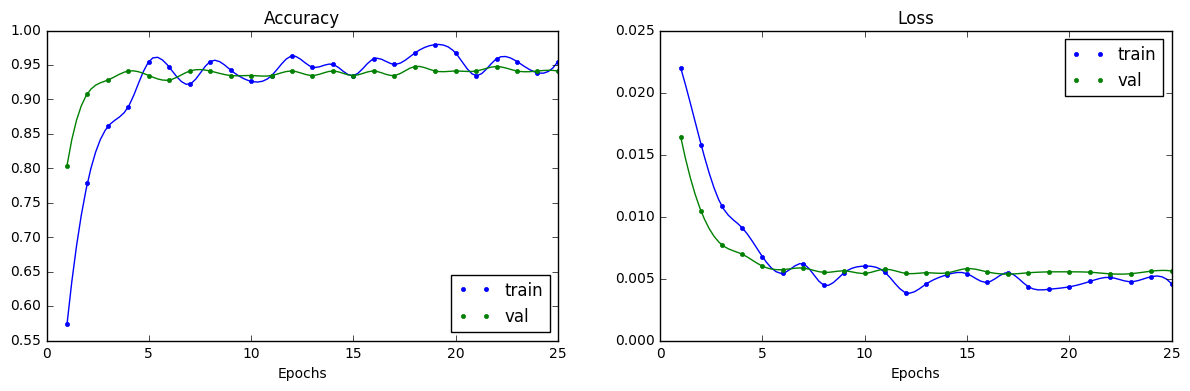

In [17]:
dataset_name = "Dataset Hymenoptera (finetunning)"
plot_metrics(metrics, dataset_name)
df.at[dataset_name, val_acc] = max(metrics['val_acc'])

In [18]:
model, metrics = freeze_and_train(data_hymenoptera, MODEL_NAME, SETS, EPOCHS, 1, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS)


Epoch 1/25
----------
train Loss: 0.0272 Acc: 0.3811
val Loss: 0.0246 Acc: 0.4706

Epoch 2/25
----------
train Loss: 0.0199 Acc: 0.6680
val Loss: 0.0151 Acc: 0.8366

Epoch 3/25
----------
train Loss: 0.0142 Acc: 0.8402
val Loss: 0.0107 Acc: 0.9085

Epoch 4/25
----------
train Loss: 0.0118 Acc: 0.8648
val Loss: 0.0087 Acc: 0.9216

Epoch 5/25
----------
train Loss: 0.0115 Acc: 0.8648
val Loss: 0.0080 Acc: 0.9477

Epoch 6/25
----------
train Loss: 0.0083 Acc: 0.9057
val Loss: 0.0077 Acc: 0.9150

Epoch 7/25
----------
train Loss: 0.0086 Acc: 0.8975
val Loss: 0.0077 Acc: 0.9412

Epoch 8/25
----------
train Loss: 0.0071 Acc: 0.9139
val Loss: 0.0069 Acc: 0.9542

Epoch 9/25
----------
train Loss: 0.0072 Acc: 0.9344
val Loss: 0.0070 Acc: 0.9542

Epoch 10/25
----------
train Loss: 0.0072 Acc: 0.9139
val Loss: 0.0069 Acc: 0.9542

Epoch 11/25
----------
train Loss: 0.0079 Acc: 0.9098
val Loss: 0.0072 Acc: 0.9477

Epoch 12/25
----------
train Loss: 0.0084 Acc: 0.9139
val Loss: 0.0067 Acc: 0.9412



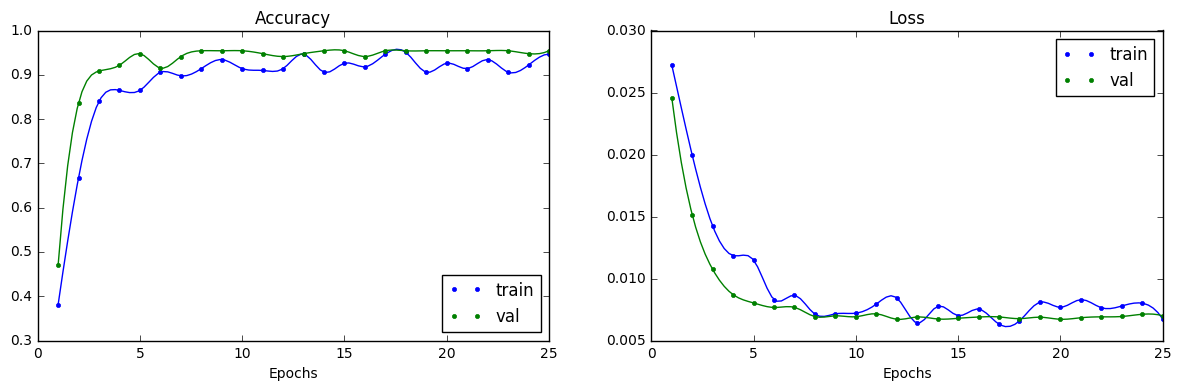

In [19]:
dataset_name = "Dataset Hymenoptera (freeze and train)"
plot_metrics(metrics, dataset_name)
df.at[dataset_name, val_acc] = max(metrics['val_acc'])

In [23]:
model, metrics = finetune(data_hymenoptera_gray, MODEL_NAME, SETS, EPOCHS, 1, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS)


Epoch 1/25
----------
train Loss: 0.0123 Acc: 0.4918
val Loss: 0.0138 Acc: 0.6209

Epoch 2/25
----------
train Loss: 0.0106 Acc: 0.6230
val Loss: 0.0118 Acc: 0.6797

Epoch 3/25
----------
train Loss: 0.0088 Acc: 0.6967
val Loss: 0.0091 Acc: 0.8039

Epoch 4/25
----------
train Loss: 0.0082 Acc: 0.7500
val Loss: 0.0084 Acc: 0.8431

Epoch 5/25
----------
train Loss: 0.0059 Acc: 0.8607
val Loss: 0.0063 Acc: 0.8497

Epoch 6/25
----------
train Loss: 0.0053 Acc: 0.9016
val Loss: 0.0070 Acc: 0.8693

Epoch 7/25
----------
train Loss: 0.0050 Acc: 0.8975
val Loss: 0.0061 Acc: 0.8693

Epoch 8/25
----------
train Loss: 0.0049 Acc: 0.8811
val Loss: 0.0061 Acc: 0.8758

Epoch 9/25
----------
train Loss: 0.0044 Acc: 0.9016
val Loss: 0.0059 Acc: 0.8758

Epoch 10/25
----------
train Loss: 0.0038 Acc: 0.9467
val Loss: 0.0058 Acc: 0.8824

Epoch 11/25
----------
train Loss: 0.0040 Acc: 0.9385
val Loss: 0.0063 Acc: 0.8824

Epoch 12/25
----------
train Loss: 0.0044 Acc: 0.9098
val Loss: 0.0059 Acc: 0.8824



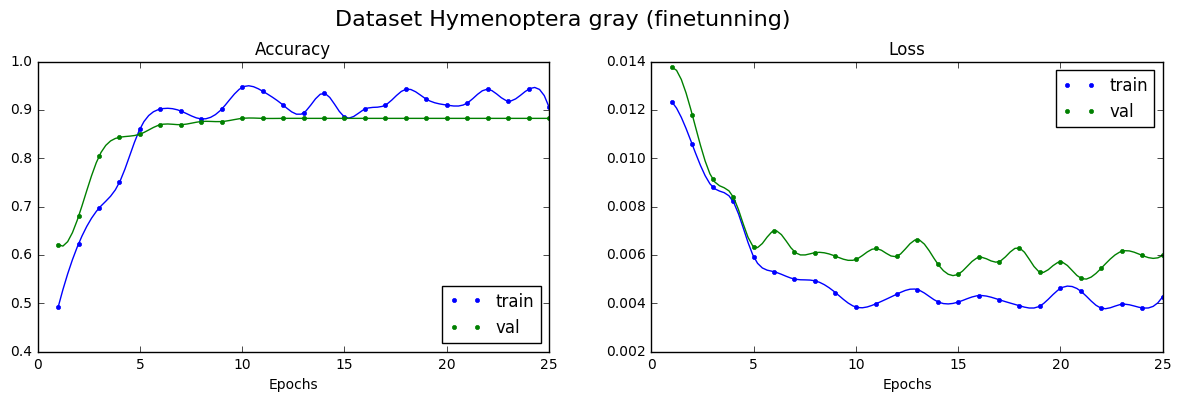

In [24]:
dataset_name = "Dataset Hymenoptera gray (finetunning)"
plot_metrics(metrics, dataset_name)
df.at[dataset_name, val_acc] = max(metrics['val_acc'])

In [25]:
model, metrics = freeze_and_train(data_hymenoptera_gray, MODEL_NAME, SETS, EPOCHS, 1, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS)


Epoch 1/25
----------
train Loss: 0.0113 Acc: 0.5287
val Loss: 0.0133 Acc: 0.6078

Epoch 2/25
----------
train Loss: 0.0110 Acc: 0.5738
val Loss: 0.0122 Acc: 0.6667

Epoch 3/25
----------
train Loss: 0.0102 Acc: 0.6311
val Loss: 0.0106 Acc: 0.7386

Epoch 4/25
----------
train Loss: 0.0091 Acc: 0.7295
val Loss: 0.0094 Acc: 0.8105

Epoch 5/25
----------
train Loss: 0.0080 Acc: 0.8238
val Loss: 0.0089 Acc: 0.8170

Epoch 6/25
----------
train Loss: 0.0077 Acc: 0.8156
val Loss: 0.0078 Acc: 0.8301

Epoch 7/25
----------
train Loss: 0.0063 Acc: 0.8852
val Loss: 0.0078 Acc: 0.8497

Epoch 8/25
----------
train Loss: 0.0066 Acc: 0.8648
val Loss: 0.0070 Acc: 0.8627

Epoch 9/25
----------
train Loss: 0.0067 Acc: 0.8443
val Loss: 0.0072 Acc: 0.8431

Epoch 10/25
----------
train Loss: 0.0061 Acc: 0.8689
val Loss: 0.0068 Acc: 0.8562

Epoch 11/25
----------
train Loss: 0.0064 Acc: 0.8811
val Loss: 0.0067 Acc: 0.8693

Epoch 12/25
----------
train Loss: 0.0063 Acc: 0.8607
val Loss: 0.0068 Acc: 0.8693



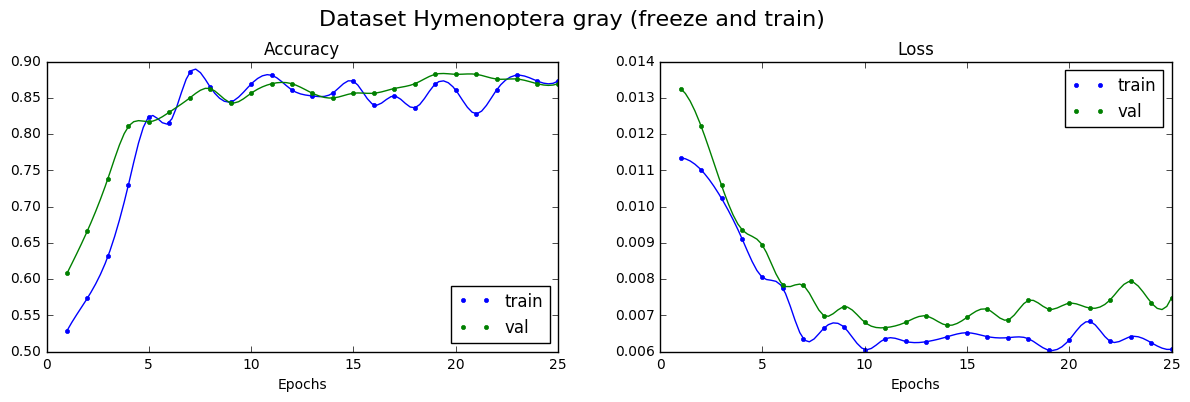

In [26]:
dataset_name = "Dataset Hymenoptera gray (freeze and train)"
plot_metrics(metrics, dataset_name)
df.at[dataset_name, val_acc] = max(metrics['val_acc'])

Transfer learning with Simpsons dataset

In [38]:
model, metrics = finetune(data_simpsons, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS)


Epoch 1/25
----------
train Loss: 0.0108 Acc: 0.1929
val Loss: 0.0092 Acc: 0.4171

Epoch 2/25
----------
train Loss: 0.0081 Acc: 0.4998
val Loss: 0.0057 Acc: 0.7041

Epoch 3/25
----------
train Loss: 0.0059 Acc: 0.6549
val Loss: 0.0037 Acc: 0.7941

Epoch 4/25
----------
train Loss: 0.0047 Acc: 0.7087
val Loss: 0.0027 Acc: 0.8402

Epoch 5/25
----------
train Loss: 0.0039 Acc: 0.7490
val Loss: 0.0023 Acc: 0.8637

Epoch 6/25
----------
train Loss: 0.0035 Acc: 0.7731
val Loss: 0.0019 Acc: 0.8852

Epoch 7/25
----------
train Loss: 0.0033 Acc: 0.7882
val Loss: 0.0017 Acc: 0.9015

Epoch 8/25
----------
train Loss: 0.0031 Acc: 0.8009
val Loss: 0.0016 Acc: 0.9008

Epoch 9/25
----------
train Loss: 0.0030 Acc: 0.8027
val Loss: 0.0017 Acc: 0.9041

Epoch 10/25
----------
train Loss: 0.0031 Acc: 0.8001
val Loss: 0.0017 Acc: 0.9033

Epoch 11/25
----------
train Loss: 0.0030 Acc: 0.8013
val Loss: 0.0016 Acc: 0.9023

Epoch 12/25
----------
train Loss: 0.0030 Acc: 0.8034
val Loss: 0.0016 Acc: 0.9077



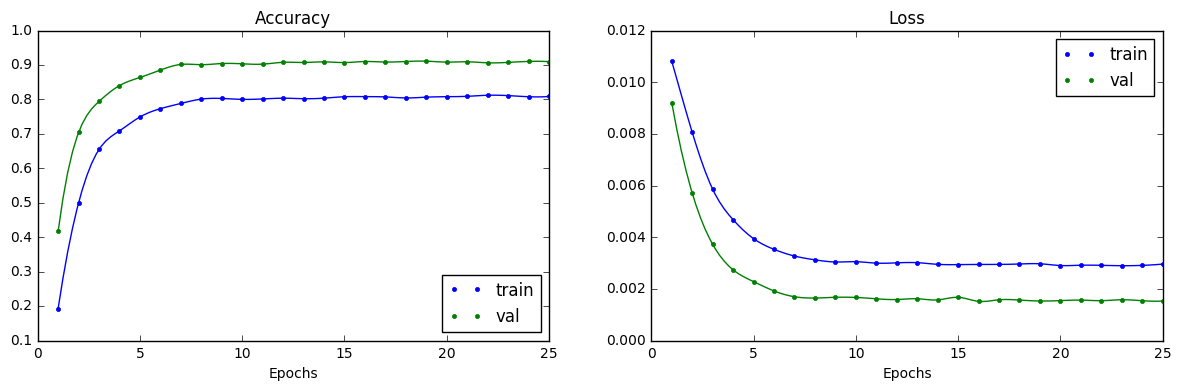

In [39]:
dataset_name = "Dataset Simpsons (finetunning)"
plot_metrics(metrics, dataset_name)
df.at[dataset_name, val_acc] = max(metrics['val_acc'])

In [47]:
model, metrics = freeze_and_train(data_simpsons, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS)


Epoch 1/25
----------
train Loss: 0.0113 Acc: 0.1292
val Loss: 0.0109 Acc: 0.1951

Epoch 2/25
----------
train Loss: 0.0102 Acc: 0.2500
val Loss: 0.0098 Acc: 0.3662

Epoch 3/25
----------
train Loss: 0.0094 Acc: 0.3561
val Loss: 0.0089 Acc: 0.4514

Epoch 4/25
----------
train Loss: 0.0088 Acc: 0.4162
val Loss: 0.0083 Acc: 0.5169

Epoch 5/25
----------
train Loss: 0.0083 Acc: 0.4627
val Loss: 0.0077 Acc: 0.5458

Epoch 6/25
----------
train Loss: 0.0079 Acc: 0.4919
val Loss: 0.0073 Acc: 0.5724

Epoch 7/25
----------
train Loss: 0.0076 Acc: 0.5210
val Loss: 0.0069 Acc: 0.6064

Epoch 8/25
----------
train Loss: 0.0074 Acc: 0.5293
val Loss: 0.0069 Acc: 0.6054

Epoch 9/25
----------
train Loss: 0.0074 Acc: 0.5270
val Loss: 0.0068 Acc: 0.6064

Epoch 10/25
----------
train Loss: 0.0073 Acc: 0.5334
val Loss: 0.0068 Acc: 0.6092

Epoch 11/25
----------
train Loss: 0.0073 Acc: 0.5342
val Loss: 0.0068 Acc: 0.6087

Epoch 12/25
----------
train Loss: 0.0073 Acc: 0.5403
val Loss: 0.0067 Acc: 0.6136



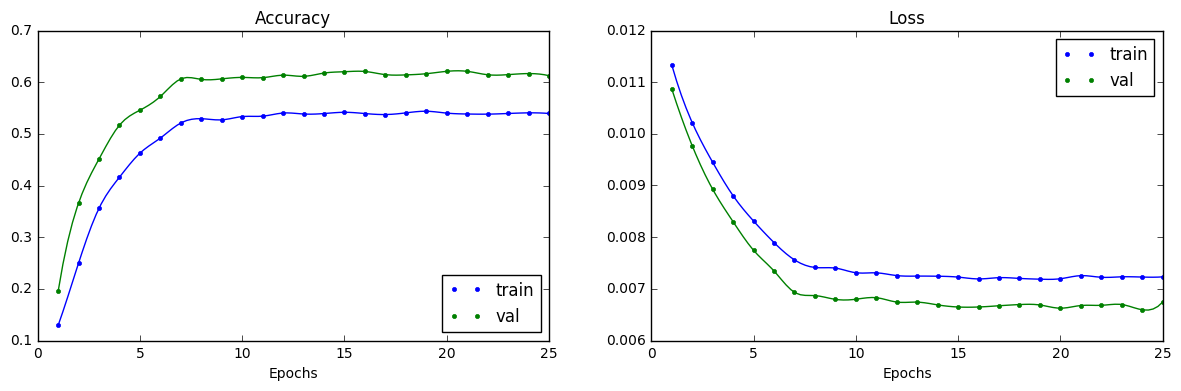

In [48]:
dataset_name = "Dataset Simpsons (freeze and train)"
plot_metrics(metrics, dataset_name)
df.at[dataset_name, val_acc] = max(metrics['val_acc'])

In [31]:
model, metrics = finetune(data_simpsons_gray, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS)


Epoch 1/25
----------
train Loss: 0.0110 Acc: 0.1633
val Loss: 0.0098 Acc: 0.3128

Epoch 2/25
----------
train Loss: 0.0089 Acc: 0.3836
val Loss: 0.0070 Acc: 0.5857

Epoch 3/25
----------
train Loss: 0.0070 Acc: 0.5464
val Loss: 0.0048 Acc: 0.7230

Epoch 4/25
----------
train Loss: 0.0058 Acc: 0.6209
val Loss: 0.0036 Acc: 0.7910

Epoch 5/25
----------
train Loss: 0.0051 Acc: 0.6662
val Loss: 0.0030 Acc: 0.8266

Epoch 6/25
----------
train Loss: 0.0045 Acc: 0.6947
val Loss: 0.0025 Acc: 0.8509

Epoch 7/25
----------
train Loss: 0.0041 Acc: 0.7183
val Loss: 0.0022 Acc: 0.8665

Epoch 8/25
----------
train Loss: 0.0041 Acc: 0.7245
val Loss: 0.0022 Acc: 0.8683

Epoch 9/25
----------
train Loss: 0.0039 Acc: 0.7362
val Loss: 0.0022 Acc: 0.8708

Epoch 10/25
----------
train Loss: 0.0039 Acc: 0.7357
val Loss: 0.0022 Acc: 0.8719

Epoch 11/25
----------
train Loss: 0.0039 Acc: 0.7317
val Loss: 0.0021 Acc: 0.8762

Epoch 12/25
----------
train Loss: 0.0039 Acc: 0.7351
val Loss: 0.0021 Acc: 0.8731



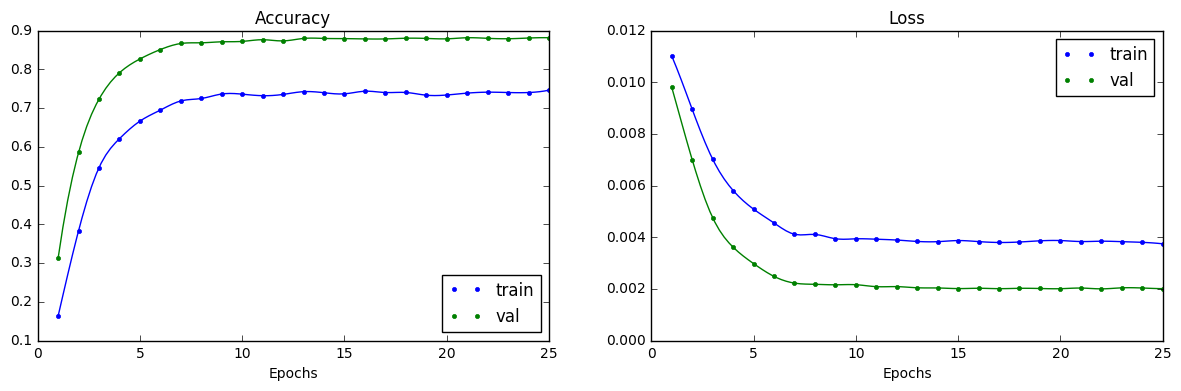

In [32]:
dataset_name = "Dataset Simpsons gray (finetunning)"
plot_metrics(metrics, dataset_name)
df.at[dataset_name, val_acc] = max(metrics['val_acc'])

In [33]:
model, metrics = freeze_and_train(data_simpsons_gray, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS)


Epoch 1/25
----------
train Loss: 0.0115 Acc: 0.1114
val Loss: 0.0112 Acc: 0.1598

Epoch 2/25
----------
train Loss: 0.0106 Acc: 0.1935
val Loss: 0.0103 Acc: 0.2514

Epoch 3/25
----------
train Loss: 0.0100 Acc: 0.2697
val Loss: 0.0096 Acc: 0.3478

Epoch 4/25
----------
train Loss: 0.0095 Acc: 0.3273
val Loss: 0.0091 Acc: 0.3913

Epoch 5/25
----------
train Loss: 0.0091 Acc: 0.3653
val Loss: 0.0086 Acc: 0.4448

Epoch 6/25
----------
train Loss: 0.0088 Acc: 0.3909
val Loss: 0.0082 Acc: 0.4711

Epoch 7/25
----------
train Loss: 0.0085 Acc: 0.4248
val Loss: 0.0079 Acc: 0.4834

Epoch 8/25
----------
train Loss: 0.0084 Acc: 0.4238
val Loss: 0.0079 Acc: 0.5000

Epoch 9/25
----------
train Loss: 0.0083 Acc: 0.4276
val Loss: 0.0078 Acc: 0.5015

Epoch 10/25
----------
train Loss: 0.0084 Acc: 0.4281
val Loss: 0.0078 Acc: 0.4939

Epoch 11/25
----------
train Loss: 0.0083 Acc: 0.4277
val Loss: 0.0077 Acc: 0.4974

Epoch 12/25
----------
train Loss: 0.0083 Acc: 0.4367
val Loss: 0.0078 Acc: 0.5082



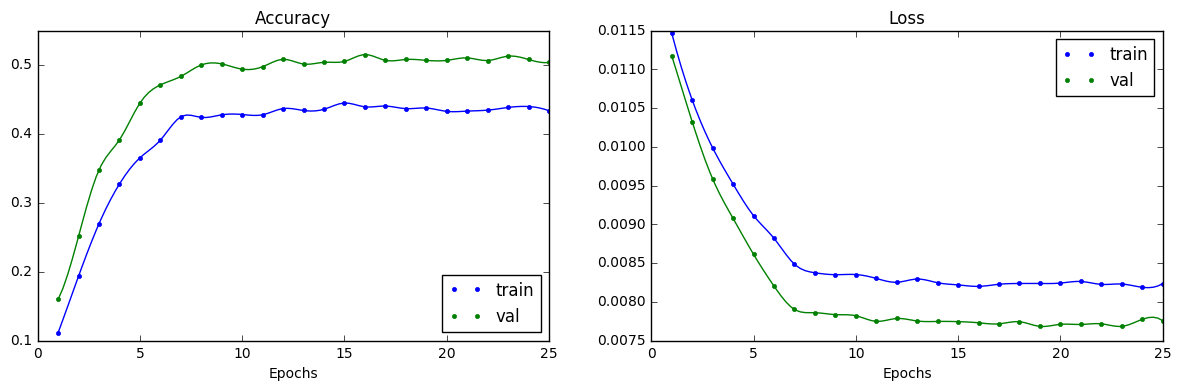

In [34]:
dataset_name = "Dataset Simpsons gray (freeze and train)"
plot_metrics(metrics, dataset_name)
df.at[dataset_name, val_acc] = max(metrics['val_acc'])

Transfer learning with dogs vs cats

In [17]:
model, metrics = finetune(data_dogs_vs_cats, MODEL_NAME, SETS, 5, NUM_GPUS, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS)


Epoch 1/5
----------
train Loss: 0.0010 Acc: 0.8968
val Loss: 0.0002 Acc: 0.9816

Epoch 2/5
----------
train Loss: 0.0005 Acc: 0.9426
val Loss: 0.0002 Acc: 0.9856

Epoch 3/5
----------
train Loss: 0.0005 Acc: 0.9510
val Loss: 0.0002 Acc: 0.9866

Epoch 4/5
----------
train Loss: 0.0004 Acc: 0.9543
val Loss: 0.0001 Acc: 0.9872

Epoch 5/5
----------
train Loss: 0.0004 Acc: 0.9549
val Loss: 0.0001 Acc: 0.9868
Training complete in 4m 2s
Best val Acc: 0.987200


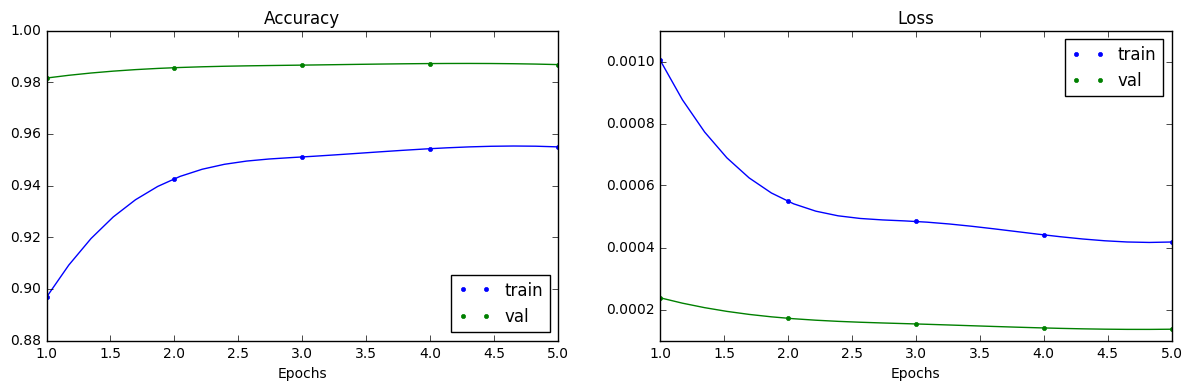

In [18]:
dataset_name = "Dataset Dogs vs Cats (finetunning)"
plot_metrics(metrics, dataset_name)
df.at[dataset_name, val_acc] = max(metrics['val_acc'])

In [19]:
model, metrics = freeze_and_train(data_dogs_vs_cats, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS)


Epoch 1/5
----------
train Loss: 0.0012 Acc: 0.8813
val Loss: 0.0004 Acc: 0.9708

Epoch 2/5
----------
train Loss: 0.0007 Acc: 0.9278
val Loss: 0.0003 Acc: 0.9762

Epoch 3/5
----------
train Loss: 0.0006 Acc: 0.9354
val Loss: 0.0003 Acc: 0.9768

Epoch 4/5
----------
train Loss: 0.0006 Acc: 0.9346
val Loss: 0.0003 Acc: 0.9802

Epoch 5/5
----------
train Loss: 0.0006 Acc: 0.9350
val Loss: 0.0003 Acc: 0.9746
Training complete in 3m 58s
Best val Acc: 0.980200


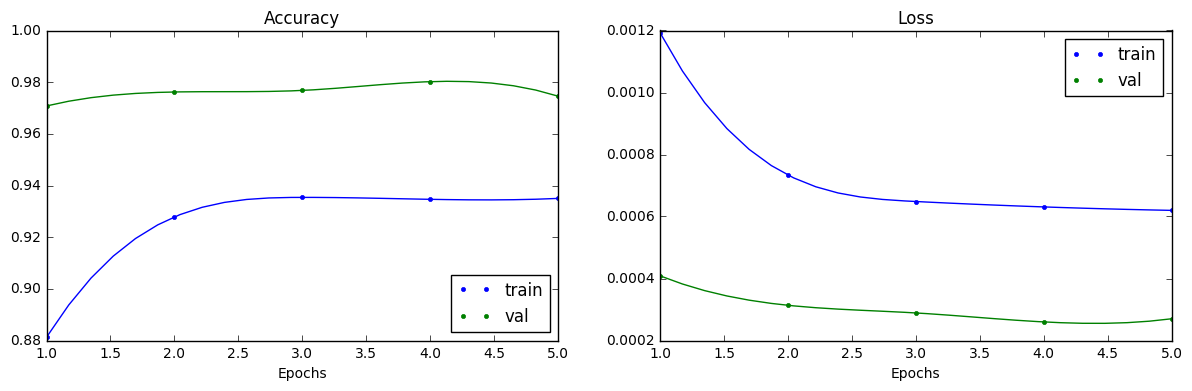

In [20]:
dataset_name = "Dataset Dogs vs Cats (freeze and train)"
plot_metrics(metrics, dataset_name)
df.at[dataset_name, val_acc] = max(metrics['val_acc'])

In [24]:
model, metrics = finetune(data_dogs_vs_cats_gray, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS)


Epoch 1/5
----------
train Loss: 0.0011 Acc: 0.8823
val Loss: 0.0003 Acc: 0.9780

Epoch 2/5
----------
train Loss: 0.0006 Acc: 0.9343
val Loss: 0.0002 Acc: 0.9806

Epoch 3/5
----------
train Loss: 0.0005 Acc: 0.9424
val Loss: 0.0002 Acc: 0.9822

Epoch 4/5
----------
train Loss: 0.0005 Acc: 0.9469
val Loss: 0.0002 Acc: 0.9806

Epoch 5/5
----------
train Loss: 0.0005 Acc: 0.9486
val Loss: 0.0002 Acc: 0.9852
Training complete in 3m 56s
Best val Acc: 0.985200


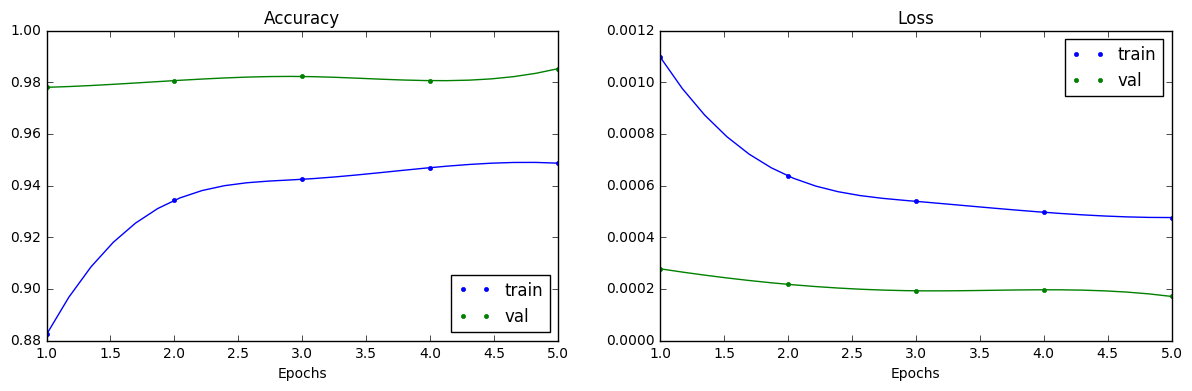

In [25]:
dataset_name = "Dataset Dogs vs Cats gray (finetunning)"
plot_metrics(metrics, dataset_name)
df.at[dataset_name, val_acc] = max(metrics['val_acc'])

In [26]:
model, metrics = freeze_and_train(data_dogs_vs_cats_gray, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS)


Epoch 1/5
----------
train Loss: 0.0014 Acc: 0.8437
val Loss: 0.0005 Acc: 0.9604

Epoch 2/5
----------
train Loss: 0.0009 Acc: 0.9109
val Loss: 0.0004 Acc: 0.9656

Epoch 3/5
----------
train Loss: 0.0008 Acc: 0.9147
val Loss: 0.0004 Acc: 0.9698

Epoch 4/5
----------
train Loss: 0.0008 Acc: 0.9184
val Loss: 0.0003 Acc: 0.9682

Epoch 5/5
----------
train Loss: 0.0007 Acc: 0.9213
val Loss: 0.0003 Acc: 0.9722
Training complete in 3m 54s
Best val Acc: 0.972200


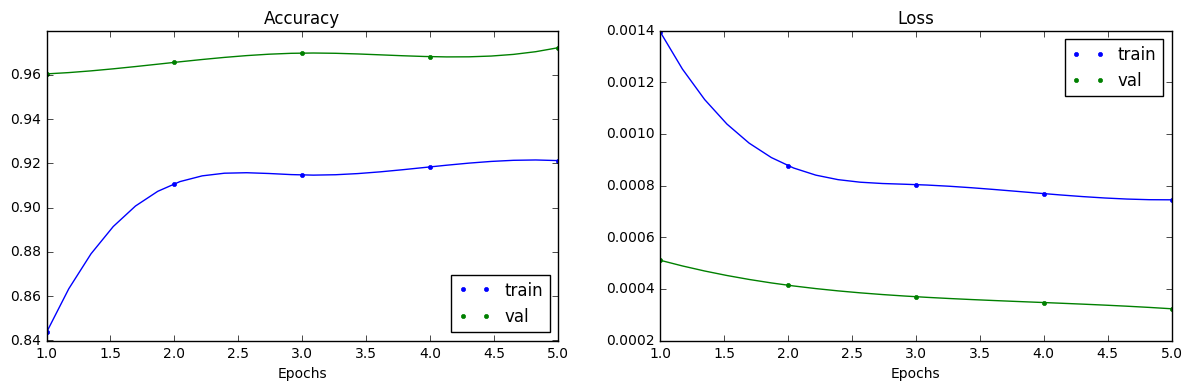

In [27]:
dataset_name = "Dataset Dogs vs Cats gray (freeze and train)"
plot_metrics(metrics, dataset_name)
df.at[dataset_name, val_acc] = max(metrics['val_acc'])

In [ ]:
model, metrics = finetune(data_caltech256, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS)

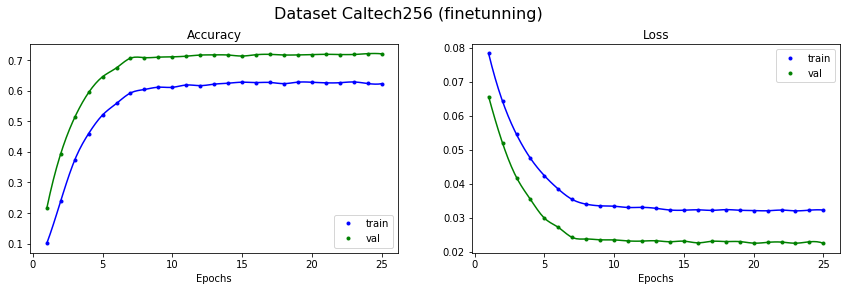

In [21]:
dataset_name = "Dataset Caltech256 (finetunning)"
plot_metrics(metrics, dataset_name)
df.at[dataset_name, val_acc] = max(metrics['val_acc'])

In [ ]:
model, metrics = freeze_and_train(data_caltech256, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS)

In [ ]:
dataset_name = "Dataset Caltech256 (freeze and train)"
plot_metrics(metrics, dataset_name)
df.at[dataset_name, val_acc] = max(metrics['val_acc'])

In [ ]:
model, metrics = finetune(data_caltech256_gray, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                          MOMENTUM, LR_STEP, LR_EPOCHS)

In [ ]:
dataset_name = "Dataset Caltech256 gray (finetunning)"
plot_metrics(metrics, dataset_name)
df.at[dataset_name, val_acc] = max(metrics['val_acc'])

In [ ]:
model, metrics = freeze_and_train(data_caltech256_gray, MODEL_NAME, SETS, EPOCHS, NUM_GPUS, LR, 
                                  MOMENTUM, LR_STEP, LR_EPOCHS)

In [ ]:
dataset_name = "Dataset Caltech256 gray (freeze and train)"
plot_metrics(metrics, dataset_name)
df.at[dataset_name, val_acc] = max(metrics['val_acc'])

In [ ]:
df